In [18]:
import pandas as pd
import scipy as sp
from scipy.sparse import diags
import numpy as np
from numpy import linalg as LA
import sys


import matplotlib.pyplot as plt

#importing seaborn for plotting
import seaborn as sns

#for plotting purposes
%pylab inline
sns.set_style('ticks')
sns.set_context('paper')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib as mpl

# mpl.rcParams
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = [8, 16/3]

Populating the interactive namespace from numpy and matplotlib


## functions for use in processing

In [47]:
#porting from HITRACE
#based on Baseline correction for NMR spectroscopic metabolomics data analysis. 2008, 
#Author(s): Xi, Yuanxin and Rocke, David M
#https://doi.org/10.1186/1471-2105-9-324 and further modified by Rhiju (Stanford University)
#name of variables tracks closely to what is presented in the manuscript

def baseline_xi(b,A=2e9,B=2e4,s=1.0):
    # Input: 
    # b Nx1, spectrum data
    # A 1x1 smoothing factor
    # B 1x1 negative penalty
    # s 1x1 noise standard deviation

    # Output:
    # bd Nx1 baseline
    # b_subtract Nx1 background subtracted trace

    L = len(b)

    # b is the SIGNAL (gamma in the paper). bd is the estimated baseline (b in the paper).
    bd = np.ones((L,1))*np.median(b)
    bd0 = b

    #current error
    nm = LA.norm(b-bd0)
    nm0 = sys.float_info.max #initialize with largest possible float

    #solving D*bd = m
    #D and m have been divided through by A
    #Mistake in expression for M; should be +1, not -1
    M0 = s*np.ones((L,1))/A

    #initialize D matrix
    e = np.ones((L,1))
    diagonals = [2, -8, 12, -8, 2]
    D0 = diags(diagonals, np.arange(-2,3), shape=(L,L)).toarray()
    
    D0[0,0] = 2
    D0[L-1,L-1] = 2

    D0[1,0] = -4
    D0[0,1] = -4
    D0[L-1,L-2] = -4
    D0[L-2,L-1]= -4

    D0[1,1] = 10
    D0[L-2,L-2] = 10

    #index for iteration
    i=0

    while ((nm>10 or i<5) and i<30):
        i=i+1
        M = M0
        D = D0
        bd0 = bd
        nm0=nm #not sure this is needed, nm0 not used in iteration

        for j in np.arange(0,L):
            if (bd[j]>b[j]):
                M[j] = M[j] + 2*(B/A)*b[j]
                D[j,j] = D[j,j] + 2*(B/A)

        bd = solve(D,M).flatten() #need to flatten to convert to 1D array
        nm = LA.norm(bd0-bd)
    
    b_subtract = b-bd
    return b_subtract,bd

#### functions for finding peaks and calculating areas

In [97]:
from scipy.signal import find_peaks

###returns indices for peaks for a given trace as well as the values at the peaks
def find_trace_peaks(trace, min_distance=100, min_height=2.5):
    
    peak_idx, _ = find_peaks(trace, distance=min_distance, height=min_height)  
    peak_val = trace[peak_idx]

    return peak_idx, peak_val



In [78]:
def return_peak_areas(start_nt, end_nt, trace, trace_nt, ctrl_start=200, ctrl_end = 300):
    #start_nt and end_nt should flank the peak of interest
    #trace refers to the reading values (FU on the Bioanalyzer)
    #trace_nt refers to the x-axis, or the nucleotides corresponding to different values in trace
    #ctrl_start, and ctrl_end refer to P4P6 control, and is flanking a wider nucleotide window to account for accumulation
    #of background, degraded RNAs
    
    #indices for P4P6
    p4p6_start_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-ctrl_start))
    p4p6_end_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-ctrl_end))

    #indices for mRNA
    first_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-start_nt))
    last_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-end_nt)) 
    
    #calculating areas
    p4p6_area = np.trapz(y=trace[p4p6_start_idx:p4p6_end_idx], x=nts[p4p6_start_idx:p4p6_end_idx])
    background_area = np.trapz(y=[trace[first_idx], trace[last_idx]], x=[nts[first_idx],nts[last_idx]])
    total_area = np.trapz(y=trace[first_idx:last_idx], x=nts[first_idx:last_idx])
    
    subtracted_area = total_area-background_area
    normalized_area = subtracted_area/p4p6_area
    
    return p4p6_area, background_area, total_area, subtracted_area, normalized_area


def calc_frac_intact(times, norm_areas):
    
    init_val = float(norm_areas[0])
    frac_intact = (norm_areas/init_val).clip(0)
    
    return frac_intact

In [79]:
from scipy.optimize import curve_fit

#returns indices, bootstrapped
def bootstrap_inds(x):
    bs_indices = np.random.choice(range(len(x)),len(x))
    return bs_indices

#function for exponential fitting
def func(x, b):
    return np.exp(-b*x)


def exp_fit(frac_intact, timepoints, func, bs_iter = 1000):
    fit_coeffs = []
    for i in np.arange(0,bs_iter,1):
        
        #just in case
        frac_intact = np.clip(a=frac_intact, a_min=0, a_max=max(frac_intact))
        
        #generate bootstrap indices
        bs_indices = bootstrap_inds(frac_intact)
        
        #generating data for fit
        fit_t = [timepoints[i] for i in bs_indices]
        fit_fracint = [frac_intact[i] for i in bs_indices]
        
        #exponential fit
        popt, pcov = curve_fit(func, fit_t, fit_fracint)
        
        fit_coeffs.append(popt[0])
    
    return fit_coeffs

# Analysis of samples starts here:

### appending file names from each sample

In [80]:
### read in sample map
map_df = pd.read_csv('sample_nucleotide_filename.csv')
# map_df

#match plate number to filename:
filenames_df = pd.read_csv('platenumber_filename.csv')
# filenames_df
filenames_dict = dict(zip(filenames_df['Plate_Number'],filenames_df['File_Name']))
# filenames_dict

#mapping plate number to filename, adding column to map
filenames = []
for filename, filenum in zip(map_df['Plate'], map_df['FileNumber']):
    name = filenames_dict[filename]
    name = name+'_'+str(filenum)+'_nts.csv'
    filenames.append(name)

map_df['FileName'] = filenames
# map_df

### directory for data:

In [81]:
data_dir = './Analysis_DSK/'

In [ ]:
map_df

Text(0.5, 1.0, 'RNA-1_natural_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_natural_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_5mC_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-1_PSU_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_5mC_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-2_PSU_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_5mC_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-3_PSU_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_5mC_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-4_PSU_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_5mC_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-7_PSU_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_5mC_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_0.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_0.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_1.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_1.5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_2.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_3.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_4.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_5.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_18.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'RNA-8_PSU_24.0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

,Sample,Nucleotide,Timepoint,Plate,FileNumber,FileName,peak_nts,start_nt,end_nt,p4p6_area,background_area,total_area,subtracted_area,normalized_area,double_normalized
0,RNA-1,natural,0.0,1,1,Eukaryote Total RNA Nano_2020-10-21_16-07-11_1...,"[23.462005828246504, 233.88945221897475, 923.3...",823.353721,1023.353721,621.663726,1923.284713,3789.719624,1866.434910,3.002322,0.021690
1,RNA-1,natural,0.5,1,2,Eukaryote Total RNA Nano_2020-10-21_16-07-11_2...,"[23.462005828246504, 233.88945221897475, 923.3...",823.353721,1023.353721,353.311820,1014.802600,1735.897457,721.094857,2.040959,0.014408
2,RNA-1,natural,1.0,1,3,Eukaryote Total RNA Nano_2020-10-21_16-07-11_3...,"[23.462005828246504, 233.88945221897475, 923.3...",823.353721,1023.353721,332.866184,788.545941,1164.331158,375.785218,1.128938,0.007615
3,RNA-1,natural,1.5,1,4,Eukaryote Total RNA Nano_2020-10-21_16-07-11_4...,"[23.462005828246504, 233.88945221897475, 923.3...",823.353721,1023.353721,323.111256,519.346921,750.447130,231.100209,0.715234,0.004894
4,RNA-1,natural,2.0,1,5,Eukaryote Total RNA Nano_2020-10-21_16-07-11_5...,"[23.462005828246504, 233.88945221897475, 923.3...",823.353721,1023.353721,329.917992,543.168957,719.230555,176.061598,0.533653,0.003668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,RNA-8,PSU,3.0,13,6,Eukaryote Total RNA Nano_2020-10-22_12-33-14_6...,"[23.45635272964645, 299.9983755882819, 870.948...",770.948104,970.948104,208.690747,116.269108,614.008437,497.739329,2.385057,0.020169
126,RNA-8,PSU,4.0,13,7,Eukaryote Total RNA Nano_2020-10-22_12-33-14_7...,"[23.45635272964645, 299.9983755882819, 870.948...",770.948104,970.948104,232.819007,126.986488,572.653756,445.667268,1.914222,0.017483
127,RNA-8,PSU,5.0,13,8,Eukaryote Total RNA Nano_2020-10-22_12-33-14_8...,"[23.45635272964645, 299.9983755882819, 870.948...",770.948104,970.948104,132.284443,85.031895,277.049889,192.017994,1.451554,0.012967
128,RNA-8,PSU,18.0,13,9,Eukaryote Total RNA Nano_2020-10-22_12-33-14_9...,"[23.45635272964645, 299.9983755882819, 870.948...",770.948104,970.948104,254.566940,89.366114,158.863462,69.497348,0.273002,0.002389


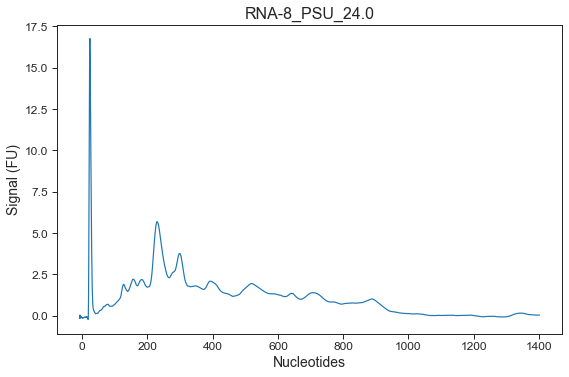

In [154]:
peak_nts_list = []
start_nt_list = []
end_nt_list = []
p4p6_area_list = []
bg_area_list = []
total_area_list = []
subtract_area_list = []
normalized_area_list = []
signal_normalized_area_list = []

peaks_nt_dict = {}
# Iterate through the list of samples, and return a df that has nucleotides and background subtracted values
for row in map_df.itertuples():
    clf()
    #read in dataframe for given sample
    sample_df = pd.read_csv(data_dir+row.FileName)
    
    #extract time series and nucleotides, let's clip to just the first third (up to ~1400 nucleotides)
    array_len = len(sample_df['Nucleotides'])
    clip_len = int(array_len/2.2)
    
    nts = np.array(sample_df['Nucleotides'][:clip_len])
    trace = np.array(sample_df['Value'][:clip_len])
    plot(nts, trace, label=row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    
    if (row.Timepoint == 0):
        peak_idx, peak_val = find_trace_peaks(trace,min_distance=100, min_height=1)
        peak_nts = nts[peak_idx]
        peak_nts_list.append(peak_nts)
        
        start_nt = nts[peak_idx][-1]-100
        end_nt = nts[peak_idx][-1]+100
        
        start_nt_list.append(start_nt)
        end_nt_list.append(end_nt)
        
        peak_assign_dict = {}
        peak_assign_dict['start_nt'] = start_nt
        peak_assign_dict['end_nt'] = end_nt
        peak_assign_dict['peaks'] = peak_nts
        
        peaks_nt_dict[(row.Sample, row.Nucleotide)] = peak_assign_dict

    else:
        time_0_dict = peaks_nt_dict[(row.Sample, row.Nucleotide)]
        peak_nts_list.append(time_0_dict['peaks'])
        start_nt_list.append(time_0_dict['start_nt'])
        end_nt_list.append(time_0_dict['end_nt'])
        
        start_nt = time_0_dict['start_nt']
        end_nt = time_0_dict['end_nt']

    
    title(row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    xlabel('Nucleotides')
    ylabel('Signal (FU)')
    tight_layout()
    
    savefig(row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint)+'.png', dpi=300)
    
#     #integrate at specified nucleotides per sample
#     start_nt = nts[peak_idx][-1]-100
#     end_nt = nts[peak_idx][-1]+100
#     start_nt_list.append(start_nt)
#     end_nt_list.append(end_nt)
    
    p4p6, background, total, subtract, normalized = return_peak_areas(start_nt, end_nt, trace, nts)
    p4p6_area_list.append(p4p6)
    bg_area_list.append(background)
    total_area_list.append(total)
    subtract_area_list.append(subtract)
    normalized_area_list.append(normalized)
    
    _,_,control_area_25, _, _ = return_peak_areas(start_nt=5, end_nt = 50, trace=trace, trace_nt=nts)
    double_normalized = normalized/control_area_25
    signal_normalized_area_list.append(double_normalized)
    

map_df = map_df.assign(peak_nts = peak_nts_list, start_nt = start_nt_list, end_nt = end_nt_list,\
              p4p6_area = p4p6_area_list, background_area = bg_area_list, total_area = total_area_list,\
              subtracted_area = subtract_area_list, normalized_area = normalized_area_list, double_normalized = signal_normalized_area_list)

map_df
#export dataframe to .csv for recordkeeping
map_df.to_csv('10-21-2020_analyzed_samples_doublenormalized.csv')

#plot configuration
# title('Background Subtracted Traces')
# xlabel('Nucleotides')
# ylabel('Signal (FU)')
# tight_layout()
# savefig('10-21-2020_traces.png', dpi=300)

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{('RNA-1', '5mC'): {'kdeg': 1.0462467770526434,
  'kdeg_err': 0.05778623557663159},
 ('RNA-1', 'PSU'): {'kdeg': 0.7889734174511588,
  'kdeg_err': 0.06158094759637865},
 ('RNA-1', 'natural'): {'kdeg': 0.9603964552334566,
  'kdeg_err': 0.04399486471456786},
 ('RNA-2', '5mC'): {'kdeg': 0.27334814897886445,
  'kdeg_err': 0.025388702721908837},
 ('RNA-2', 'PSU'): {'kdeg': 0.14935305143434258,
  'kdeg_err': 0.00934717369416622},
 ('RNA-3', '5mC'): {'kdeg': 0.928930196350496,
  'kdeg_err': 0.042560221481499495},
 ('RNA-3', 'PSU'): {'kdeg': 0.9513909870970266,
  'kdeg_err': 0.20526768318366334},
 ('RNA-4', '5mC'): {'kdeg': 0.45216412098006675,
  'kdeg_err': 0.025581514192605626},
 ('RNA-4', 'PSU'): {'kdeg': 0.09896140898346788,
  'kdeg_err': 0.015997848556522382},
 ('RNA-7', '5mC'): {'kdeg': 0.5557818150983228,
  'kdeg_err': 0.02579249494621692},
 ('RNA-7', 'PSU'): {'kdeg': 0.36407202614084905,
  'kdeg_err': 0.03785361911671707},
 ('RNA-8', '5mC'): {'kdeg': 0.5610647344730785,
  'kdeg_err': 0.

Text(0.5, 1.0, 'Fraction Intact')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

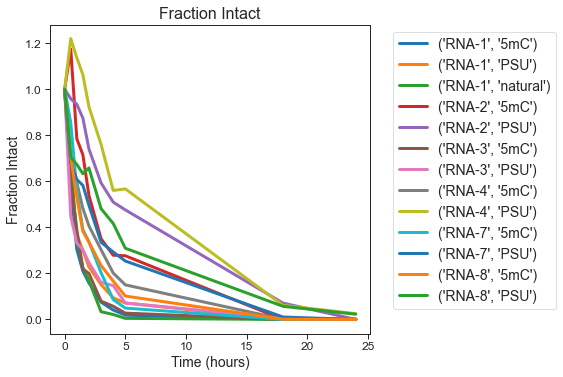

In [155]:
#all combinations of sample and nucleotide type
samples = set(zip(map_df['Sample'], map_df['Nucleotide']))

sample_dfs = []
sample_fits = {}
for sample in sorted(samples):
    rna_sample = sample[0]
    nucleotide = sample[1]

    working_df = map_df[(map_df['Sample']==rna_sample) & (map_df['Nucleotide']==nucleotide)]
#     working_df
    
#     norm_areas = np.array(working_df['normalized_area'])
    norm_areas = np.array(working_df['double_normalized'])
    times = np.array(working_df['Timepoint'])
    
    frac_intact = calc_frac_intact(times, norm_areas)
    working_df['Frac_Intact'] = frac_intact
    
    plot(times, frac_intact, label=sample, linewidth=3)
    
    fits = exp_fit(timepoints=times, frac_intact=frac_intact, func=func)
    kdeg = np.mean(fits)
    kdeg_err = np.std(fits)
    
    fit_dict = {}
    fit_dict['kdeg'] = kdeg
    fit_dict['kdeg_err'] = kdeg_err
    
    sample_fits[sample] = fit_dict
    
sample_fits
legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
title('Fraction Intact')
xlabel('Time (hours)')
ylabel('Fraction Intact')
tight_layout()

,level_0,level_1,kdeg,kdeg_err
0,RNA-1,5mC,1.046247,0.057786
1,RNA-1,PSU,0.788973,0.061581
2,RNA-1,natural,0.960396,0.043995
3,RNA-2,5mC,0.273348,0.025389
4,RNA-2,PSU,0.149353,0.009347
5,RNA-3,5mC,0.928930,0.042560
6,RNA-3,PSU,0.951391,0.205268
7,RNA-4,5mC,0.452164,0.025582
8,RNA-4,PSU,0.098961,0.015998
9,RNA-7,5mC,0.555782,0.025792


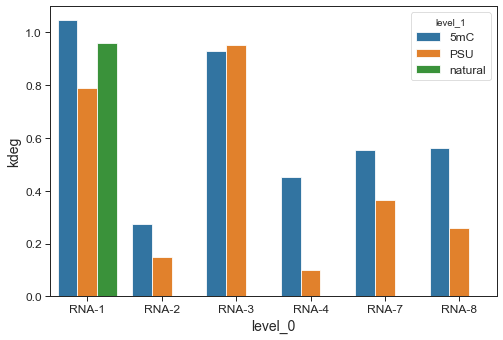

In [156]:
fits_df = pd.DataFrame(sample_fits).T
fits_df = fits_df.reset_index()

fits_df.rename({'level_0': 'Sample', 'level_1': 'Nucleotide'})

sns.barplot(data=fits_df, y='kdeg', x='level_0', hue='level_1')